In [10]:
import comet_ml
experiment = comet_ml.start()

from policy_bench.util import setup_cache, setup_logging
setup_logging()
setup_cache()
import logging
logger = logging.getLogger("policy_bench")
logger.setLevel('INFO')

import argon.random
import argon.transforms as agt
import argon.numpy as npx
import argon.ott as ott
import argon.train
import argon.tree
import argon.random
import argon.policy as policy
import argon.random

import argon.store.comet
import seaborn as sns
sns.set_theme()
sns.set_style("whitegrid")

import argon.store
import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Deja Vu Serif"
    # "font.family": "Charter BT Roman"
})
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

COMET INFO: An experiment with the same configuration options is already running and will be reused.


In [11]:
from policy_bench.methods.diffusion_policy import DiffusionPolicy

artifact = experiment.get_artifact("lower_bound-stable-1-diffusion_policy:43.0.0")
checkpoint : DiffusionPolicy = argon.store.comet.from_artifact(artifact)
artifact = experiment.get_artifact("lower_bound-stable-1-diffusion_policy:44.0.0")
mc_checkpoint : DiffusionPolicy = argon.store.comet.from_artifact(artifact)
artifact = experiment.get_artifact("lower_bound-stable-1-diffusion_policy:45.0.0")
hc_checkpoint : DiffusionPolicy = argon.store.comet.from_artifact(artifact)

In [12]:
from argon.registry import Registry
from policy_bench.envs.lower_bounds import register_envs
dataset = checkpoint.data.create_dataset()
registry = Registry()
register_envs(registry)
env_alt = registry.create("lower_bound/stable/2")
env = dataset.env()

In [13]:
def rollout(checkpoint, mc_checkpoint, hc_checkpoint, rng):
    diffusion_policy = checkpoint.create_policy()
    diffusion_policy_mc = mc_checkpoint.create_policy()
    diffusion_policy_hc = hc_checkpoint.create_policy()
    expert = env.create_expert()
    @agt.partial
    def zero_policy(input):
        return policy.PolicyOutput(npx.zeros_like(input.state))
    x0 = env.reset(rng)
    # x0 = npx.concatenate((npx.array([0., 0.05]), npx.zeros_like(x0[2:])))
    r_dp = policy.rollout(agt.partial(env.step), x0, diffusion_policy, length=100, 
                   policy_rng_key=argon.random.key(42))
    r_dp_mc = policy.rollout(agt.partial(env.step), x0, diffusion_policy_mc, length=100, 
                   policy_rng_key=argon.random.key(42))
    r_dp_hc = policy.rollout(agt.partial(env.step), x0, diffusion_policy_hc, length=100, 
                   policy_rng_key=argon.random.key(42))
    r_zero = policy.rollout(agt.partial(env.step), x0, zero_policy, length=100, 
                   policy_rng_key=argon.random.key(42))
    r_exp = policy.rollout(agt.partial(env.step), x0, expert, length=100, 
                   policy_rng_key=argon.random.key(42))
    alt_r_dp = policy.rollout(agt.partial(env_alt.step), x0, diffusion_policy, length=100, 
                   policy_rng_key=argon.random.key(42))
    alt_r_dp_mc = policy.rollout(agt.partial(env_alt.step), x0, diffusion_policy_mc, length=100, 
                   policy_rng_key=argon.random.key(42))
    alt_r_dp_hc = policy.rollout(agt.partial(env_alt.step), x0, diffusion_policy_hc, length=100, 
                   policy_rng_key=argon.random.key(42))
    alt_r_zero = policy.rollout(agt.partial(env_alt.step), x0, zero_policy, length=100, 
                   policy_rng_key=argon.random.key(42))
    alt_r_exp = policy.rollout(agt.partial(env_alt.step), x0, env_alt.create_expert(), length=100, 
                   policy_rng_key=argon.random.key(42))
    return (
        r_dp, r_dp_mc, r_dp_hc, r_zero, r_exp,
        alt_r_dp, alt_r_dp_mc, alt_r_dp_hc, alt_r_zero, alt_r_exp
    )

# rollout(checkpoint, argon.random.key(42))
(dp_trajs, dp_mc_trajs, dp_hc_trajs, zero_trajs, exp_trajs,
    alt_dp_trajs, alt_dp_mc_trajs, alt_dp_hc_trajs, alt_zero_trajs, alt_exp_trajs) = agt.vmap(
        rollout, in_axes=(None, None, None, 0)
    )(
        checkpoint, mc_checkpoint, hc_checkpoint,
        argon.random.split(
            argon.random.key(42), 2
        )
    )

(dp_traj, dp_mc_traj, dp_hc_traj, zero_traj, exp_traj,
    alt_dp_traj, alt_dp_mc_traj, alt_dp_hc_traj, alt_zero_traj, alt_exp_traj) = argon.tree.map(
        lambda x: x[0], (dp_trajs, dp_mc_trajs, dp_hc_trajs, zero_trajs, exp_trajs,
            alt_dp_trajs, alt_dp_mc_trajs, alt_dp_hc_trajs, alt_zero_trajs, alt_exp_trajs)
    )

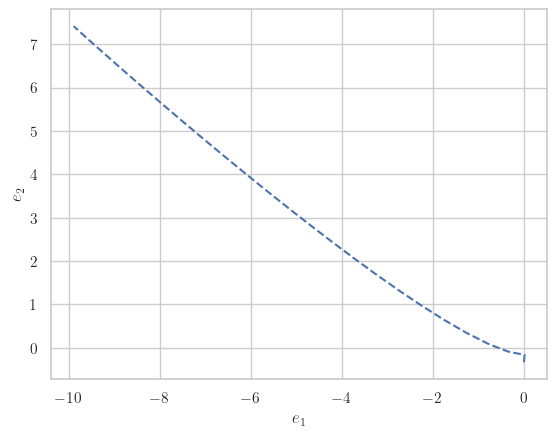

In [16]:
T = 100
plt.plot(dp_traj.states[:T, 0], dp_traj.states[:T, 1], marker=None, linestyle="--")
# plt.plot(alt_dp_traj.states[:T, 0], alt_dp_traj.states[:T, 1], marker=None)
# plt.plot(alt_zero_traj.states[:T, 0], alt_zero_traj.states[:T, 1], marker=None)
# plt.plot(alt_exp_traj.states[:T, 0], alt_exp_traj.states[:T, 1], marker=None, linestyle="--")
# plt.plot(exp_traj.states[:T, 0], exp_traj.states[:T, 1], marker=None, linestyle="--")

# plt.xlim(-0.6, 0.6)
# plt.ylim(-0.4, 0.4)
plt.xlabel("$e_1$")
plt.ylabel("$e_2$")
plt.show()

0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79


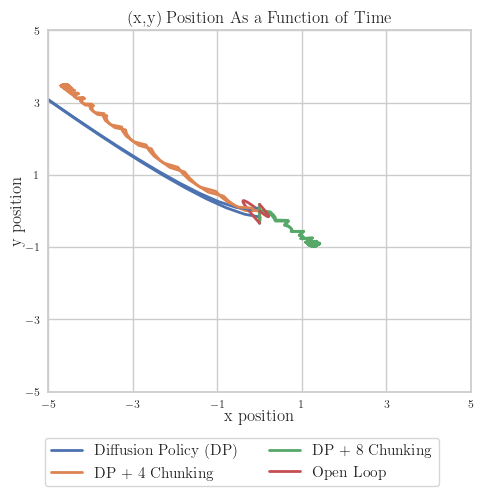

In [39]:
import matplotlib.animation as animation
def animate(i):
    t = i + 1
    print(i)
    l1.set_data(dp_traj.states[:t,0], dp_traj.states[:t,1])
    l2.set_data(dp_mc_traj.states[:t,0],dp_mc_traj.states[:t,1])
    l3.set_data(dp_hc_traj.states[:t,0],dp_hc_traj.states[:t,1])
    l4.set_data(zero_traj.states[:t,0],zero_traj.states[:t,1])

    l5.set_data(dp_trajs.states[1,:t,0], dp_trajs.states[1,:t,1])
    l6.set_data(dp_mc_trajs.states[1,:t,0], dp_mc_trajs.states[1,:t,1])
    l7.set_data(dp_hc_trajs.states[1,:t,0], dp_hc_trajs.states[1,:t,1])
    l8.set_data(zero_trajs.states[1,:t,0], zero_trajs.states[1,:t,1])
    return l1, l2, l3, l4, l5, l6, l7, l8

t = 20
fig, ax = plt.subplots()
width = 2
alt = npx.ones((t//2,)) #-((npx.arange(t) % 2) * 2 - 1)
l1 = ax.plot(dp_traj.states[:t, 0], dp_traj.states[:t, 1], linewidth=width,
        marker=None, color=colors[0], label="Diffusion Policy (DP)")[0]
l2 = ax.plot(dp_mc_traj.states[:t, 0], dp_mc_traj.states[:t, 1], linewidth=width,
        marker=None, color=colors[1], label="DP + 4 Chunking")[0]
l3 = ax.plot(dp_hc_traj.states[:t, 0], dp_hc_traj.states[:t, 1], linewidth=width,
        marker=None, color=colors[2], label="DP + 8 Chunking")[0]
l4 = ax.plot(zero_traj.states[:t, 0], zero_traj.states[:t, 1],linewidth=width,
        marker=None, color=colors[3], label="Open Loop")[0]
l5 = ax.plot(dp_trajs.states[1,:t, 0], dp_trajs.states[1,:t, 1],linewidth=width,
        marker=None, color=colors[0])[0]
l6 = ax.plot(dp_mc_trajs.states[1,:t, 0], dp_mc_trajs.states[1,:t,1],linewidth=width,
        marker=None, color=colors[1])[0]
l7 = ax.plot(dp_hc_trajs.states[1,:t, 0], dp_hc_trajs.states[1,:t, 1], linewidth=width,
        marker=None, color=colors[2])[0]
l8 = ax.plot(zero_trajs.states[0,:t,0], zero_trajs.states[0,:t, 1],linewidth=width,
        marker=None, color=colors[3])[0]
fig.legend(loc="lower center", ncol=2)
ax.set_xlabel("x position", labelpad=0)
ax.set_ylabel("y position", labelpad=0)
sx = -5.0, 5.0
sy = -5, 5
ax.set_xlim(sx[0], sx[1])
ax.set_ylim(sy[0], sy[1])
ax.set_xticks(npx.linspace(sx[0], sx[1], 6))
ax.set_yticks(npx.linspace(sy[0], sy[1], 6))
ax.tick_params(axis="x", pad=0, labelsize=8)
ax.tick_params(axis="y", pad=0, labelsize=8)
ax.set_title("(x,y) Position As a Function of Time")
fig.set_figheight(5)
fig.set_figwidth(5)
fig.tight_layout()
fig.subplots_adjust(bottom=0.2)
fig.set_dpi(100)

ani = animation.FuncAnimation(fig, animate, frames=80, interval=50)
ani.save(filename="animation.gif", writer="pillow")
plt.show()

TypeError: 'Rollout' object is not iterable

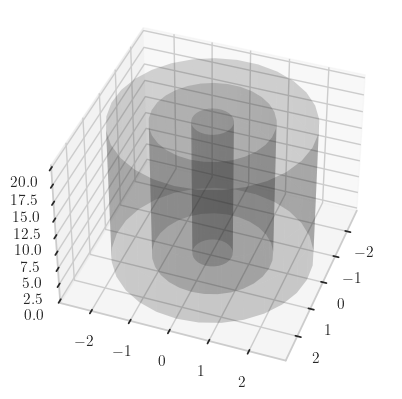

In [6]:
import itertools
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
T = 20
alt = -((npx.arange(T) % 2) * 2 - 1)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d', computed_zorder=False)
ax.view_init(elev=40, azim=20, roll=0)

def plot_cylinder(ax, center, radius, color):
    theta = npx.linspace(0, 2 * npx.pi, 30)
    z = npx.linspace(0, 20, 5)
    Theta, Z = npx.meshgrid(theta, z)
    X = radius * npx.cos(Theta) + center[0]
    Y = radius * npx.sin(Theta) + center[1]
    # ax.plot_wireframe(X, Y, Z, color=color, alpha=0.5, rstride=1, cstride=5, edgecolor=color)
    ax.plot_surface(X, Y, Z, color=color, alpha=0.2, edgecolor='none', axlim_clip=True,
                    zorder=-10.0)
plot_cylinder(ax, (0, 0.05), 0.5, (0.2, 0.2, 0.2, 0))
plot_cylinder(ax, (0, 0.05), 1.5, (0.2, 0.2, 0.2, 0))
plot_cylinder(ax, (0, 0.05), 2.5, (0.2, 0.2, 0.2, 0))
c = npx.inf
ts = npx.arange(T)
for (dp_traj, mc_traj, hc_traj, zero_traj, 
     alt_dp_traj, alt_mc_traj, alt_hc_traj, alt_zero_traj,
     color) in zip(
                dp_trajs, dp_mc_trajs, dp_hc_trajs, zero_trajs, 
                alt_dp_trajs, alt_dp_mc_trajs, alt_dp_hc_trajs, alt_zero_trajs,
                itertools.cycle(colors)
            ):
    clip = True
    width = 2
    ax.plot(dp_traj[:T, 0], dp_traj[:T, 1], ts, axlim_clip=clip, linewidth=width,
             marker=None, color=colors[0], label="Diffusion Policy (DP)")
    ax.plot(mc_traj[:T, 0], mc_traj[:T, 1], ts, axlim_clip=clip, linewidth=width,
             marker=None, color=colors[1], label="DP + 4 Chunking")
    ax.plot(hc_traj[:T, 0], hc_traj[:T, 1], ts, axlim_clip=clip, linewidth=width,
             marker=None, color=colors[2], label="DP + 8 Chunking")
    ax.plot(zero_traj[:T, 0], zero_traj[:T, 1], ts, axlim_clip=clip, linewidth=width,
             marker=None, color=colors[3], label="Open Loop")
    ax.plot(alt_dp_traj[:T, 0]*alt, dp_traj[:T, 1], ts, axlim_clip=clip, linewidth=width,
             marker=None, color=colors[0])
    ax.plot(alt_mc_traj[:T, 0]*alt, mc_traj[:T, 1], ts, axlim_clip=clip, linewidth=width,
             marker=None, color=colors[1])
    ax.plot(alt_hc_traj[:T, 0]*alt, hc_traj[:T, 1], ts, axlim_clip=clip, linewidth=width,
             marker=None, color=colors[2])
    ax.plot(alt_zero_traj[:T, 0]*alt, zero_traj[:T, 1], ts, axlim_clip=clip, linewidth=width,
             marker=None, color=colors[3])
    break

fig.legend(loc="lower center", ncol=2)
ax.set_xlabel("x position", labelpad=0)
ax.set_ylabel("y position", labelpad=0)
ax.zaxis.set_rotate_label(False) 
ax.set_zlabel("Timestep", rotation=95, labelpad=0)
sx = -3.0, 1.0
sy = -1, 3
ax.set_xlim(sx[0], sx[1])
ax.set_ylim(sy[0], sy[1])
ax.set_zlim(0, 30)

ax.set_xticks(npx.linspace(sx[0], sx[1], 6))
ax.set_yticks(npx.linspace(sy[0], sy[1], 6))

ax.tick_params(axis="x", pad=0, labelsize=8)
ax.tick_params(axis="y", pad=0, labelsize=8)
ax.tick_params(axis="z", pad=0, labelsize=8)

for axis in [ax.xaxis, ax.yaxis, ax.zaxis]:
    axis._axinfo['axisline']['linewidth'] = 0.1
    axis._axinfo['axisline']['color'] = (0.2, 0.2, 0.2)
    axis._axinfo['grid']['linewidth'] = 0.5
    axis._axinfo['grid']['linestyle'] = "--"
    axis._axinfo['grid']['color'] = (0.1, 0.1, 0.1)
    # axis._axinfo['tick']['inward_factor'] = 0.0
    # axis._axinfo['tick']['outward_factor'] = 0.0

ax.zaxis._axinfo["grid"].update({"color": (1., 1., 1., 0.)})

ax.set_title("(x,y) Position As a Function of Time")
fig.tight_layout()
fig.subplots_adjust(left=0.25, right=0.8, top=0.9, bottom=0.15)
fig.set_dpi(300)
fig.show()

# fig.savefig("open_loop_stable.pdf", bbox_inches='tight', pad_inches=0.1)
